In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [2]:
# Read the cleaned file to dataframe
df = pd.read_csv('../Backorder_clean_withTransitOutlier.csv')
df.tail()

,product_id,current_inventory,transit_duration,prior_sales_1_month,prior_sales_3_month,prior_sales_6_month,prior_sales_9_month,minimum_recommended_stock,source_performance_6_months,source_performance_12_months,deck_risk,ppap_risk,stop_auto_buy,went_on_backorder
1687827,1407754,0.0,2.0,0.0,5.0,7.0,7.0,0.0,0.69,0.69,Yes,No,Yes,No
1687828,1373987,-1.0,8.0,1.0,3.0,3.0,8.0,0.0,0.84,0.83,No,No,Yes,No
1687829,1524346,-1.0,9.0,0.0,8.0,11.0,12.0,0.0,0.86,0.84,Yes,No,No,Yes
1687830,1439563,62.0,9.0,35.0,63.0,153.0,205.0,12.0,0.86,0.84,No,No,Yes,No
1687831,1502009,19.0,4.0,2.0,7.0,12.0,20.0,1.0,0.73,0.78,No,No,Yes,No


In [3]:
# Devide the dataset 
X = pd.DataFrame(df.columns)
X = df[df.columns]
y =df['went_on_backorder']
# make the traget values numeric
y = y.replace('Yes', 1)
y= y.replace('No', 0)


In [4]:
# Drop the features which is not important
X = X.drop(['went_on_backorder','deck_risk', 'ppap_risk', 'stop_auto_buy','product_id'], axis=1, errors='ignore')
X.shape, df.shape

((1687832, 9), (1687832, 14))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42) 
X_train.shape , y_train.shape,  X_test.shape

((1181482, 9), (1181482,), (506350, 9))

So till now we have **cleaned-up the data and performed the default classification** to check the **precision score on 20% of the data**. Based on the analysis until now, I chose to move ahead with** RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier**.  My next step will be to tune all the three models and train them with 70% of the data. Rest **30% will be used for validation**.

## RandomForestClassifier Tuning and Training

In [7]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"n_estimators":[10, 20 , 50],
              "max_features":['auto', 'sqrt', 'log2'],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf":[5, 10, 50]
             }

# Instantiate a Decision Tree classifier: tree
tree = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV (tree, param_dist, cv=5, scoring='precision',n_jobs=-1)

# Fit it to the data
tree_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'n_estimators': 50, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}
Best score is 0.7851527438133301


</br>
For tuning the parameters of the model,  I used a mix of cross-validation and randomize search. Here is the Tuned parameters of ** RandomForestClassifier : {'n_estimators': 50, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}**

I used **10 fold for cross Validation** and mean precision is **0.80211790393**
30% unseen Test data precion score is** 0.80**
</br>



In [10]:
# Tuned RandomForestClassifier and cross validated
rfmodel= RandomForestClassifier(n_estimators=50, criterion='entropy', max_features='sqrt' ,random_state=30)
rfModel_Precision = cross_val_score(rfmodel , X_train, y_train, cv=10, scoring='precision', n_jobs=-1)
print(rfModel_Precision)
print(rfModel_Precision.mean())


[ 0.80864198  0.80898876  0.7715736   0.87356322  0.83139535  0.8343949
  0.78142077  0.75647668  0.75144509  0.80327869]
0.80211790393


In [31]:
# Test the model with 30% Test data
y_test_pred= rfModel_tuned.predict(X_test)
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00    488617
          1       0.80      0.21      0.34      3304

avg / total       0.99      0.99      0.99    491921



# GradientBoostingClassifier Tuning and Training

</br>
For tuning the parameters of the model,  I used a mix of cross-validation and randomize search. Here is the Tuned parameters of ** GradientBoostingClassifier : {'subsample': 0.5, 'n_estimators': 200, 'min_samples_leaf': 100, 'max_depth': 4, 'learning_rate': 0.01}
**

I used **10 fold for cross Validation** and mean precision is **0.80211790393**
30% unseen Test data precion score is** 0.52** which is quite less as compare to RandomForestClassifier
</br>


In [11]:
# Setup the parameters and distributions to sample from: param_dist

param_dist = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
               'min_samples_leaf': [5, 20, 50,100,150],
              'n_estimators': [100, 200, 500],
              'subsample':[.5, .8, 1]}

# Instantiate a Decision Tree classifier: tree
gm = GradientBoostingClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
gm_cv = RandomizedSearchCV(gm, param_dist, cv=5, scoring='precision',n_jobs=-1)

# Fit it to the data
gm_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(gm_cv.best_params_))
print("Best score is {}".format(gm_cv.best_score_))

Tuned Decision Tree Parameters: {'subsample': 1, 'n_estimators': 200, 'min_samples_leaf': 50, 'learning_rate': 0.1}
Best score is 0.5208008448096729


In [12]:
# Tuned GradientBoostingClassifier and cross validated
gbmodel= GradientBoostingClassifier(n_estimators=200, learning_rate= 0.1, min_samples_leaf=50,subsample=1, random_state=32)
gbmodel_Precision = cross_val_score(gbmodel , X_train, y_train, cv=10, scoring='precision', n_jobs=-1)
print(gbmodel_Precision)
print(gbmodel_Precision.mean())

[ 0.53846154  0.5         0.33333333  0.64285714  0.5         0.70588235
  0.66666667  0.57142857  0.68421053  0.52941176]
0.567225189671


# AdaBoostClassifier Tuning and Training

In [9]:
abmodel= AdaBoostClassifier(base_estimator=rfmodel ,random_state = 32)
abmodel.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=30, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=32)

In [13]:
abmodel_prediction = abmodel.predict( X_test )
abmodel_report = classification_report(y_test, abmodel_prediction )
#print the report
print(abmodel_report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    502921
          1       0.81      0.28      0.41      3429

avg / total       0.99      0.99      0.99    506350



Based on the performance of all the predictive model I found **Tuned AdaBoostClassifier with base classifier as tuned RandomForestClassifier** is the most suitable predictive model to choose here.
I will recommend this model to client as it has **precision score of .81.**


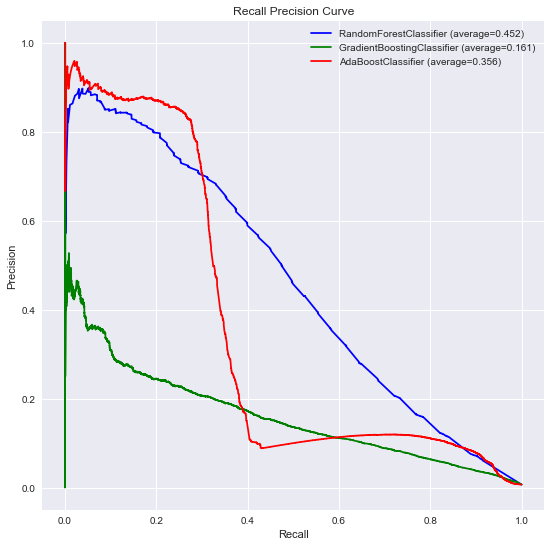

In [10]:
#plot Recall-Precision Curves
fig , ax1 = plt.subplots(figsize=(9,9) )
estimators =[rfmodel, gbmodel, abmodel]
classifiers=['RandomForestClassifier','GradientBoostingClassifier',
           'AdaBoostClassifier']
colors = ['b', 'g', 'r']
for i, estimator in enumerate(estimators):
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test,y_pred_prob)
    average_precision= average_precision_score(y_test, y_pred_prob, average="micro")
    plt.plot(recall, precision, label='%s (average=%.3f)'%(classifiers[i],average_precision), color=colors[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Recall Precision Curve')